# Load dataset


In [102]:
from pathlib import Path

base_path = Path(".").absolute().parents[0]

In [104]:
import sys

sys.path.insert(0, str(base_path / "src"))

In [106]:
from google.cloud import bigquery

client = bigquery.Client(project="artefact-taxonomy")


from utils.text_utils import clean_html
from sklearn.model_selection import train_test_split

In [107]:
CUTOFF = 5

# Define the product_id and target / label
id_col = "adeo_product_id"
title_col = "title"
language_col = "lang"
description_raw = "description"
description_col = "description_clean"
label_raw_col = "mirakl_model_code"

In [108]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

In [109]:
df = pd.read_csv('../data/train.csv')

In [125]:
df.attribute_code.zfill(5)

AttributeError: 'Series' object has no attribute 'zfill'

In [124]:
str(df.attribute_code[0]).zfill(5)

'02419'

# Prepare data in the correct format based on unique ID


In [110]:
adeo_id_list = df['adeo_product_id'].unique().tolist()
for each_product in adeo_id_list:
    lang = df[language_col].loc[df['adeo_product_id'] == int(each_product)].tolist()
    for each_lang in lang:
        # put the row in each language
        single_row = df.loc[(df['adeo_product_id'] == int(each_product)) & (df[language_col] == each_lang)]
        single_row['attribute_code'] = 99999
        single_row['attribute_label'] = 'product_model'
        single_row['lov_code'] = single_row['step_model_code']
        df = pd.concat([df, single_row])

df = df.reset_index(drop=True)

In [111]:
df.groupby('attribute_code').count()

,adeo_product_id,id,title,description,lang,attribute_label,attribute_type,is_multivalued,is_lov,attribute_value,lov_code,step_model_code,mirakl_model_code,data_source,description_clean
attribute_code,,,,,,,,,,,,,,,
562,10541,10541,10541,10541,10541,10541,10541,10541,10541,10541,10541,10541,10541,10541,10537
1746,6639,6639,6639,6639,6639,6639,6639,6639,6639,6639,6639,6639,6639,6639,6639
2419,12816,12816,12816,12815,12816,12816,12816,12816,12816,12816,12816,12816,12816,12816,12812
15344,10505,10505,10505,10505,10505,10505,10505,10505,10505,10505,10505,10505,10505,10505,10503
99999,47167,47167,47167,47166,47167,47167,47167,47167,47167,47167,47167,47167,47167,47167,47153


In [128]:
df['attribute_code'] = df['attribute_code'].apply(lambda x: str(x).zfill(5))
df['lov_code'] = df['lov_code'].apply(lambda x: str(x).zfill(5))

# Data Exploration

Text(0.5, 1.0, 'Histogram of each attribute')

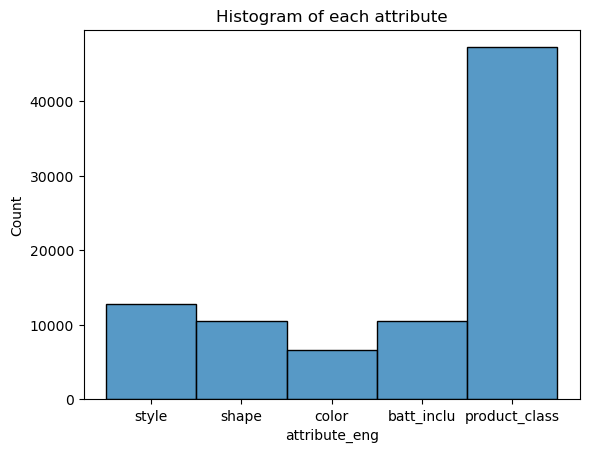

In [129]:
df['attribute_eng'] = 'None'

df['attribute_eng'].loc[df['attribute_code'] == '02419'] = 'style'
df['attribute_eng'].loc[df['attribute_code'] == '01746'] = 'color'
df['attribute_eng'].loc[df['attribute_code'] == '00562'] = 'shape'
df['attribute_eng'].loc[df['attribute_code'] == '15344'] = 'batt_inclu'
df['attribute_eng'].loc[df['attribute_code'] == '99999'] = 'product_class'

sns.histplot(data=df['attribute_eng'])

plt.title('Histogram of each attribute')

style
48
shape
54
color
77
batt_inclu
2
product_class
85


Text(0.5, 1.0, 'Number of class in each attribute')

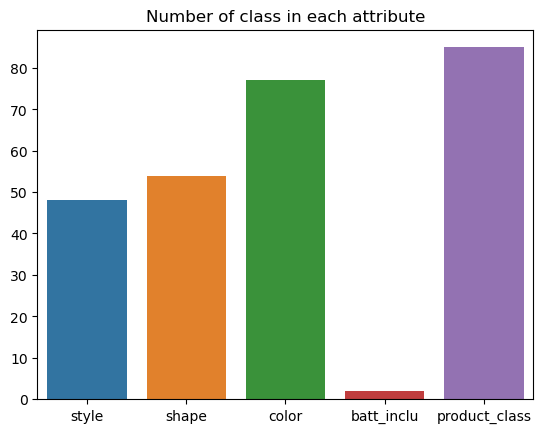

In [131]:
attribute_list = []
attribute_count = []
for attribute, attribute_eng in zip(df['attribute_code'].unique(), df['attribute_eng'].unique()):
    print (attribute_eng)
    print (len(df.loc[df['attribute_code']== attribute].groupby('lov_code').count()))
    attribute_list.append(attribute_eng)
    attribute_count.append(len(df.loc[df['attribute_code']== attribute].groupby('lov_code').count()))

sns.barplot(x=attribute_list, y=attribute_count)
plt.title('Number of class in each attribute')

# Save data in csv

In [132]:
df.to_csv("../data/train_formatted.csv", index=False)

# change the data for val and test

In [133]:
val = pd.read_csv('../data/val.csv')

adeo_id_list = val['adeo_product_id'].unique().tolist()
for each_product in adeo_id_list:
    lang = val[language_col].loc[val['adeo_product_id'] == int(each_product)].tolist()
    for each_lang in lang:
        # put the row in each language
        single_row = val.loc[(val['adeo_product_id'] == int(each_product)) & (val[language_col] == each_lang)]
        single_row['attribute_code'] = 99999
        single_row['attribute_label'] = 'product_model'
        single_row['lov_code'] = single_row['step_model_code']
        val = pd.concat([val, single_row])


val['attribute_code'] = val['attribute_code'].apply(lambda x: str(x).zfill(5))
val['lov_code'] = val['lov_code'].apply(lambda x: str(x).zfill(5))

val = val.reset_index(drop=True)

val.to_csv("../data/val_formatted.csv", index=False)

In [134]:
test = pd.read_csv('../data/test.csv')

adeo_id_list = test['adeo_product_id'].unique().tolist()
for each_product in adeo_id_list:
    lang = test[language_col].loc[test['adeo_product_id'] == int(each_product)].tolist()
    for each_lang in lang:
        # put the row in each language
        single_row = test.loc[(test['adeo_product_id'] == int(each_product)) & (test[language_col] == each_lang)]
        single_row['attribute_code'] = 99999
        single_row['attribute_label'] = 'product_model'
        single_row['lov_code'] = single_row['step_model_code']
        test = pd.concat([test, single_row])

test = test.reset_index(drop=True)

test['attribute_code'] = test['attribute_code'].apply(lambda x: str(x).zfill(5))
test['lov_code'] = test['lov_code'].apply(lambda x: str(x).zfill(5))

test = test.reset_index(drop=True)

test.to_csv("../data/test_formatted.csv", index=False)